# **PACKAGE IMPORTS AND INSTALLATIONS**

In [1]:
%%time 

from IPython.display import clear_output, HTML
from gc import collect

!pip install \
--no-index \
--find-links=/kaggle/input/package-dependencies/LAMA038 lightautoml -q

!pip install \
--no-index \
--find-links=/kaggle/input/packages-datawrangling-v1/Polars121 -q polars

collect();
clear_output();


CPU times: user 2.91 s, sys: 529 ms, total: 3.44 s
Wall time: 2min 30s


In [2]:
%%time 

from warnings import filterwarnings
filterwarnings('ignore')

from os import path, walk, getpid
from psutil import Process
import re
from collections import Counter
from itertools import product

import ctypes
libc = ctypes.CDLL("libc.so.6")

from IPython.display import display_html, clear_output
from pprint import pprint
from functools import partial
from copy import deepcopy
import pandas as pd, numpy as np, os, joblib
import polars as pl
import polars.selectors as cs
import re

from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from colorama import Fore, Style, init
from warnings import filterwarnings
filterwarnings('ignore')
from tqdm.notebook import tqdm

print()
collect()


CPU times: user 1.49 s, sys: 405 ms, total: 1.89 s
Wall time: 2.35 s


0

In [3]:
%%time 

# Pipeline specific packages:-
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# AutoML package:-
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, matthews_corrcoef

CPU times: user 37.2 s, sys: 1.28 s, total: 38.5 s
Wall time: 42 s


In [4]:
%%time

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config
set_config(transform_output = "pandas")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)
np.random.seed(42)

# Setting plots configuration:-
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        })

collect()

CPU times: user 259 ms, sys: 3.91 ms, total: 263 ms
Wall time: 259 ms


0

# **APPROACH DETAILS**

**Data columns**<br>
This is available in the original data description as [here](https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523439) <br>

**Competition details and notebook objectives**
1. This is a binary-classification challenge to predict 2 classes in the target (class). **Mathews correlation** is the metric for the challenge - **this needs to be maximized**<br>
2. In this starter notebook, we start the assignment with an auto ML solution with minimal EDA. Let's explore the dataset and build better models going ahead!<br>

|Version Number|Details|CV score|LB score|
|--------| --------| :-:|:-:|
|1       | * Auto ML without any additional transforms/ features <br> * Boosted tree models <br> * Used competition data only | | |
|2       | * Auto ML without any additional transforms/ features <br> * Boosted tree models <br> * Included original data | | |

In [5]:
%%time

class Utility:
    """
    This class serves to do the below-
    1. Define method to print in color
    2. Define the garbage cleaning process
    """;

    def PrintColor(self,text:str, color = Fore.BLUE, style = Style.BRIGHT):
        "Prints color outputs using colorama using a text F-string";
        print(style + color + text + Style.RESET_ALL)

    def ScoreMetric(self, ytrue, ypred)-> float:
        """
        This method calculates the custom metric from the imported script
        Inputs- ytrue, ypred:- input truth and predictions
        Output- float:- competition metric
        """;
        return matthews_corrcoef(ytrue, ypred)

    def CleanMemory(self):
        "This method cleans the memory off unused objects and displays the cleaned state RAM usage";

        collect();
        libc.malloc_trim(0)
        pid        = getpid()
        py         = Process(pid)
        memory_use = py.memory_info()[0] / 2. ** 30
        return f"\nRAM usage = {memory_use :.4} GB"
        
Utils = Utility()
print();



CPU times: user 94 µs, sys: 6 µs, total: 100 µs
Wall time: 104 µs


In [6]:
%%time 

# Change this to False in the actual run
test_req = False;

target     = 'class'
episode    = 8
mapper     = {"e": 0, "p": 1}
state      = 42
version_nb = 1
cutoff     = 0.60

if test_req:
    sample_frac = 0.001
    time_budget = 180
    n_splits    = 3
    algos       = ["lgb",]
    
else:
    time_budget = 12000
    n_splits    = 5
    algos       = ["lgb",  ]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


# **PREPROCESSING**

---> Train test shape = (3116945, 21) | (2077964, 20)
---> Train test shape = (3178014, 21) | (2077964, 20)


---> Test set features
array(['capdiameter', 'capshape', 'capsurface', 'capcolor', 'doesbruiseorbleed', 'gillattachment', 'gillspacing', 'gillcolor', 'stemheight', 'stemwidth',
       'stemroot', 'stemsurface', 'stemcolor', 'veiltype', 'veilcolor', 'hasring', 'ringtype', 'sporeprintcolor', 'habitat', 'season'], dtype=object)






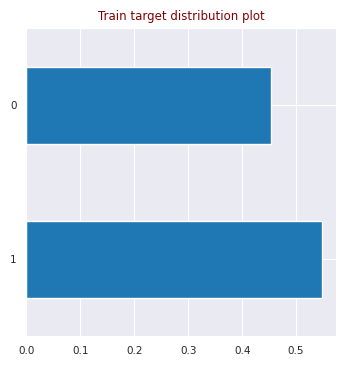


RAM usage = 1.562 GB
CPU times: user 8.59 s, sys: 2.36 s, total: 11 s
Wall time: 7.41 s


In [7]:
%%time 

train    = pd.read_parquet(f"/kaggle/input/playgrounds4e08-dataorganization/train.parquet")
test     = pd.read_parquet(f"/kaggle/input/playgrounds4e08-dataorganization/test.parquet")
sub_fl   = pd.read_parquet(f"/kaggle/input/playgrounds4e08-dataorganization/sample_submission.parquet")
original = pd.read_parquet(f"/kaggle/input/playgrounds4e08-dataorganization/original.parquet")

Utils.PrintColor(f"---> Train test shape = {train.shape} | {test.shape}");

train = pd.concat([train, original], axis=0, ignore_index = True)
train.index.name = "id"
train[target] = train[target].map(mapper).astype(np.int8)
Utils.PrintColor(f"---> Train test shape = {train.shape} | {test.shape}");   

Utils.PrintColor(f"\n\n---> Test set features")
strt_ftre = np.array(test.columns)
with np.printoptions(linewidth = 160):
    pprint(strt_ftre)

print("\n\n\n")
fig, ax = plt.subplots(1,1, figsize = (4,4))
train[target].value_counts(normalize = True).plot.barh(color = 'tab:blue', ax = ax)
ax.set_title(f"Train target distribution plot", color = "maroon")
plt.show()

Utils.PrintColor(Utils.CleanMemory())

In [8]:
%%time 

if test_req:
    train = train.groupby(target).sample(frac = 0.01)
    Utils.PrintColor(f"\n\n---> Train sample shape = {train.shape}") 
    train.index.name = "id"
    
    test   = test.iloc[0:100]
    sub_fl = sub_fl.iloc[0:100]
    
Utils.PrintColor(f"\n---> Train test shape = {train.shape} | {test.shape}");
Utils.PrintColor(Utils.CleanMemory())


---> Train test shape = (3178014, 21) | (2077964, 20)

RAM usage = 1.561 GB
CPU times: user 266 ms, sys: 0 ns, total: 266 ms
Wall time: 263 ms


# **MODEL TRAINING**

In [9]:
%%time 

drop_cols = ["id"]

Utils.PrintColor(f"\n{'=' * 20} MODEL TRAINING {'=' * 20}\n")

model = TabularAutoML(task = Task('binary', loss = 'logloss', metric = 'logloss'),
                      
                      timeout   = time_budget,
                      
                      cpu_limit = 4,
                      
                      general_params = {"use_algos": [algos]},
                      
                      nn_params = {"n_epochs"       : 100,
                                   "bs"             : 128,
                                   "num_workers"    : 0,
                                   "path_to_save"   : None,
                                   "freeze_defaults": True,
                                   "cont_embedder"  : "cont",
                                   },
                      
                      nn_pipeline_params = {"use_qnt": False, "use_te": False},
                      
                      reader_params = {'n_jobs'        : 4,
                                       'cv'            : n_splits,
                                       'random_state'  : state,
                                       'advanced_roles': False
                                       },
                      );

oof_preds = \
model.fit_predict(train,
                  roles   = {'target': target, "drop": drop_cols},
                  verbose = 1
                  );

preds = model.predict(test.drop(columns = drop_cols, errors = "ignore"))

Utils.PrintColor(Utils.CleanMemory())


==================== MODEL TRAINING ====================

[03:33:03] Stdout logging level is INFO.
[03:33:03] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[03:33:03] Task: binary

[03:33:03] Start automl preset with listed constraints:
[03:33:03] - time: 12000.00 seconds
[03:33:03] - CPU: 4 cores
[03:33:03] - memory: 16 GB

[03:33:03] Train data shape: (3178014, 21)

[03:33:08] Layer 1 train process start. Time left 11995.04 secs
[03:37:04] Selector_LightGBM fitting and predicting completed
[03:40:50] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[04:03:52] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.03644659429469049
[04:03:52] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[04:03:52] Time left 10150.54 secs

[04:03:52] Layer 1 training completed.

[04:03:52] Automl preset training completed in 1849.67 seconds

[04:03:52] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 ave

In [10]:
%%time 

Utils.PrintColor(f"\nFeature importances\n")
display(model.get_feature_scores('fast').\
        set_index("Feature").style.\
        format(formatter = '{:,.2f}').\
        bar(color = "#b3ecff")
       )

Utils.PrintColor(Utils.CleanMemory());


Feature importances



,Importance
Feature,
stemwidth,"2,905,372.38"
capsurface,"2,894,693.70"
gillspacing,"2,071,077.01"
stemcolor,"2,064,543.62"
gillattachment,"2,043,809.63"
stemsurface,"1,891,927.32"
stemheight,"1,438,972.12"
ringtype,"1,376,987.74"
stemroot,"1,230,347.55"



RAM usage = 1.702 GB
CPU times: user 331 ms, sys: 5 ms, total: 336 ms
Wall time: 342 ms


# **SUBMISSION**

In [11]:
%%time 


score = Utils.ScoreMetric(train[target].values, 
                          np.where(oof_preds.data.flatten() > 0.6,1,0))
Utils.PrintColor(f"\n---> OOF score = {score:.6f}", color = Fore.RED)

sub_fl[target] = preds.data.flatten()
sub_fl.to_parquet(f"Mdl_Preds_V{version_nb}.parquet")

pd.DataFrame(oof_preds.data.flatten(), 
             index = train.index, 
             columns = [f"LAMA_V{version_nb}"]
            ).\
to_parquet(f"OOF_Preds_LAMAV{version_nb}.parquet")

sub_fl[target] = np.where(sub_fl[target] >= 0.6, "p", "e")

Utils.PrintColor(f"\n\n---> Final submission file\n\n")
display(sub_fl.head(10).style.format(precision = 4))
sub_fl.to_csv("submission.csv", index = None)

Utils.PrintColor(Utils.CleanMemory());
!ls


---> OOF score = 0.984038


---> Final submission file




,class
id,
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e
3116950,e
3116951,e
3116952,p
3116953,p



RAM usage = 1.702 GB
Mdl_Preds_V1.parquet	  __notebook__.ipynb
OOF_Preds_LAMAV1.parquet  submission.csv
CPU times: user 4.66 s, sys: 262 ms, total: 4.92 s
Wall time: 6.15 s
